# Poisson solvers for periodic grids

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Objective

Solve Poisson's equation,

$$\nabla^2 \phi(\mathbf{r}) = -\frac{\rho(\mathbf{r})}{\epsilon_0},$$

to obtain the potential $\phi(\mathbf{r})$ from a given charge distribution $\rho(\mathbf{r})$.

## 1. Spatial discretization and direct solution

We apply a spatial discretization to the Laplace operator $\nabla^2$ (matrix) as well as the potential $\phi$ and charge density $\rho$ (vectors), and solve Poisson's equation like a linear equation

$$A \mathbf{x} = \mathbf{b}.$$

### 1.1 The 1D case

In 1D, the discrete Laplace operator applied on a function $f$ yields
$$\left(\nabla_1^2 f\right)_i = \frac{f_{i+1} + f_{i-1} - 2 f_i}{h}.$$

Thus, we have to solve the linear equation

$$\phi_{i+1} + \phi_{i-1} - 2 \phi_i = \frac{h \rho_i}{\epsilon_0}, \; i=0,\dots,n-1.$$

Lets implement a function to generate the LHS.

shape: (10, 10)


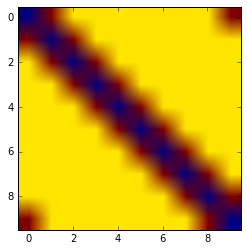

In [2]:
def laplace_1d(n):
    r"""The 1D Laplace operator independent of the grid spacing.
    
    Parameters
    ----------
    n : int
        The number of grid point along the discretized axis.
    
    Returns
    -------
    numpy.ndarray(shape=(n, n), dtype=numpy.float64)
        The Laplace operator matrix.
    
    """
    laplace = np.zeros(shape=(n, n), dtype=np.float64)
    for i in range(n):
        laplace[i, i] = -2.0
        laplace[i, (i + 1) % n] = 1.0
        laplace[i, (i - 1) % n] = 1.0
    return laplace

laplace = laplace_1d(10)
print("shape: " + str(laplace.shape))

plt.imshow(laplace);

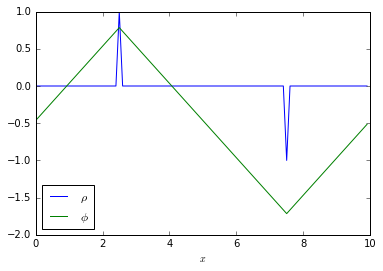

In [3]:
# q_1=+1 at x_1=2.5, q_2=-1 at x_2=7.5
laplace = laplace_1d(100)
rho = np.zeros(shape=(100,), dtype=np.float64)
rho[25] = 1.0
rho[75] = -1.0

x = np.linspace(0, 10, 100, endpoint=False)
phi = np.linalg.solve(laplace, -rho * (x[1] - x[0]))

fig, ax = plt.subplots()
ax.plot(x, rho, label=r"$\rho$")
ax.plot(x, phi, label=r"$\phi$")
ax.legend(loc=3)
ax.set_xlabel(r"$x$");

### 1.2 The 2D case

The 2D Laplace operator applied on a function $f$ yields

$$\left(\nabla_2^2 f\right)_{i,j} = \frac{f_{i+1,j} + f_{i-1,j} + f_{i,j+1} + f_{i,j-1} - 4 f_{i,j}}{h^2}.$$

**Exercise:** write down the 2D finite difference discretization of the unit-less Poisson equation ($\nabla_2^2\phi=-\rho$) on a uniform grid with cell length $d$ and bring it into the form $A\phi=\mathbf{b}$.

Lets implement the 2D Laplace operator matrix.

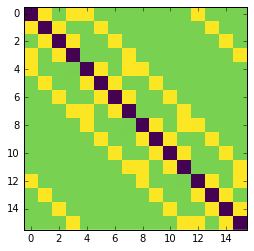

In [10]:
def laplace_2d(n, m):
    r"""The 2D Laplace operator independent of the grid spacing.
    
    Parameters
    ----------
    n : int
        The number of grid point along the x-axis.
    m : int
        The number of grid point along the y-axis.
    
    Returns
    -------
    numpy.ndarray(shape=(n * m, n * m), dtype=numpy.float64)
        The Laplace operator matrix.
    
    """
    laplace = np.zeros(shape=(n, m, n, m), dtype=np.float64)
    for i in range(n):
        for j in range(m):
            laplace[i, j, i, j] = -4.0
            laplace[i, j, (i + 1) % n, j] = 1.0
            laplace[i, j, (i - 1) % n, j] = 1.0
            laplace[i, j, i, (j + 1) % m] = 1.0
            laplace[i, j, i, (j - 1) % m] = 1.0
    return laplace.reshape((n * m, -1))

plt.imshow(laplace_2d(4, 4), interpolation='none', cmap=mpl.cm.viridis)

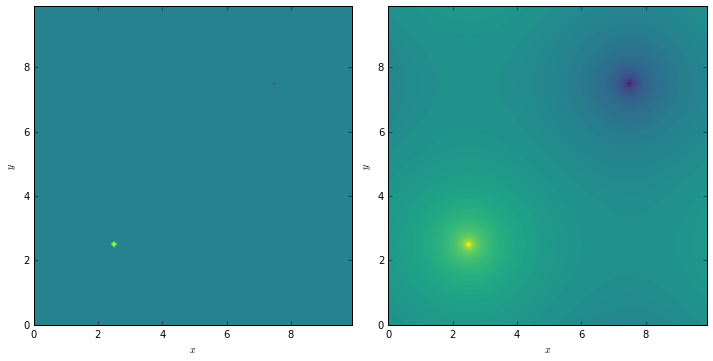

In [5]:
# q_1=+1 at (x_1,y_1)=(2.5,2.5), q_2=-1 at (x_2,y_2)=(7.5,7.5)
n, m = 100, 100
gn = np.linspace(0.0, 10.0, n, endpoint=False)
gm = np.linspace(0.0, 10.0, m, endpoint=False)
xx, yy = np.meshgrid(gn, gm, indexing="ij")

laplace = laplace_2d(n, m)

rho = np.zeros(shape=(n, m), dtype=np.float64)
rho[25, 25] = 1.0
rho[75, 75] = -1.0

phi = np.linalg.solve(laplace, -rho.reshape((-1,)) * (gn[1] - gn[0]) * (gm[1] - gm[0]))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].contourf(xx, yy, rho, cmap=mpl.cm.viridis)
axes[1].contourf(xx, yy, phi.reshape((n, m)), np.linspace(phi.min(), phi.max(), 100), cmap=mpl.cm.viridis)
for ax in axes.flat:
    ax.set_aspect("equal")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
fig.tight_layout()

### 1.3 The 3D case

The 3D Laplace operator applied on a function $f$ yields

$$\left(\nabla_3^2 f\right)_{i,j,k} = \frac{f_{i+1,j,k} + f_{i-1,j,k} + f_{i,j+1,k} + f_{i,j-1,k} + f_{i,j,k+1} + f_{i,j,k-1} - 6 f_{i,j,k}}{h^3}$$

**Exercise:** implement the 3D Laplace operator matrix.

## 2 Sparse iterative solvers

We will now look at relaxation methods to solve the linear equation iteratively.

### 2.1 The Jacobi method

**Exercise:** extend the given 1D variant to 2d and solve the above problem $q_1=+1$ at (2.5,2.5) and $q_2=-1$ at (7.5, 7.5). Compare your result with the direct solution.

In [6]:
def jacobi_1d(rho, maxerr=1.0E-8, maxiter=1000):
    r"""Solve the 1D Poisson equation using the Jacobi method.
    
    Parameters
    ----------
    rho : numpy.ndarray
        The charge density grid.
    maxerr : float, optional, default=1.eE-8
        The convergence criterion.
    maxiter : int, optional, default=1000
        The number of iterations.
    
    Returns
    -------
    numpy.ndarray(shape=rh,shape, dtype=rho.dtype)
        The potential grid.
    
    """
    phi = np.zeros(shape=rho.shape, dtype=rho.dtype)
    phi_new = np.empty_like(phi)
    for i in range(maxiter):
        phi_new[:] = rho
        phi_new[1:] += phi[:-1]
        phi_new[:-1] += phi[1:]
        phi_new[0] += phi[-1]
        phi_new[-1] += phi[0]
        phi_new *= 0.5
        if np.all(np.abs(phi_new - phi) < maxerr):
            return phi_new, i
        phi[:] = phi_new
    raise RuntimeError("Not converged after %d steps!" % maxiter)

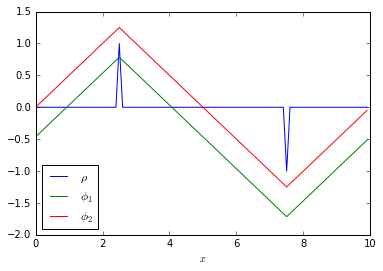

In [7]:
# q_1=+1 at x_1=2.5, q_2=-1 at x_2=7.5
laplace = laplace_1d(100)
rho = np.zeros(shape=(100,), dtype=np.float64)
rho[25] = 1.0
rho[75] = -1.0

x = np.linspace(0, 10, 100, endpoint=False)

phi1 = np.linalg.solve(laplace, -rho * (x[1] - x[0]))
phi2, iterations = jacobi_1d(rho * (x[1] - x[0]), maxerr=1.0E-15, maxiter=100000)

fig, ax = plt.subplots()
ax.plot(x, rho, label=r"$\rho$")
ax.plot(x, phi1, label=r"$\phi_1$")
ax.plot(x, phi2, label=r"$\phi_2$")
ax.legend(loc=3)
ax.set_xlabel(r"$x$");

### 2.2 The successive overrelaxation (SOR) method

**Exercise:** implement this method for 3D.